In [1]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import _pickle as pickle
import gym
import matplotlib.pyplot as plt
%matplotlib inline

# hyperparameters
H = 400 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
  model = pickle.load(open('save.p', 'rb'))
else:
  model = {}
  model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
  model['W2'] = np.random.randn(H) / np.sqrt(H)
  
grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(range(0, r.size)):
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """
  dW2 = np.dot(eph.T, epdlogp).ravel()
  dh = np.outer(epdlogp, model['W2'])
  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}

In [ ]:
################### for looking under the hood:

In [78]:
env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0

# env.render()
cur_x = prepro(observation)
x = cur_x - prev_x if prev_x is not None else np.zeros(D)
prev_x = cur_x

# forward the policy network and sample an action from the returned probability
aprob, h = policy_forward(x)
action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

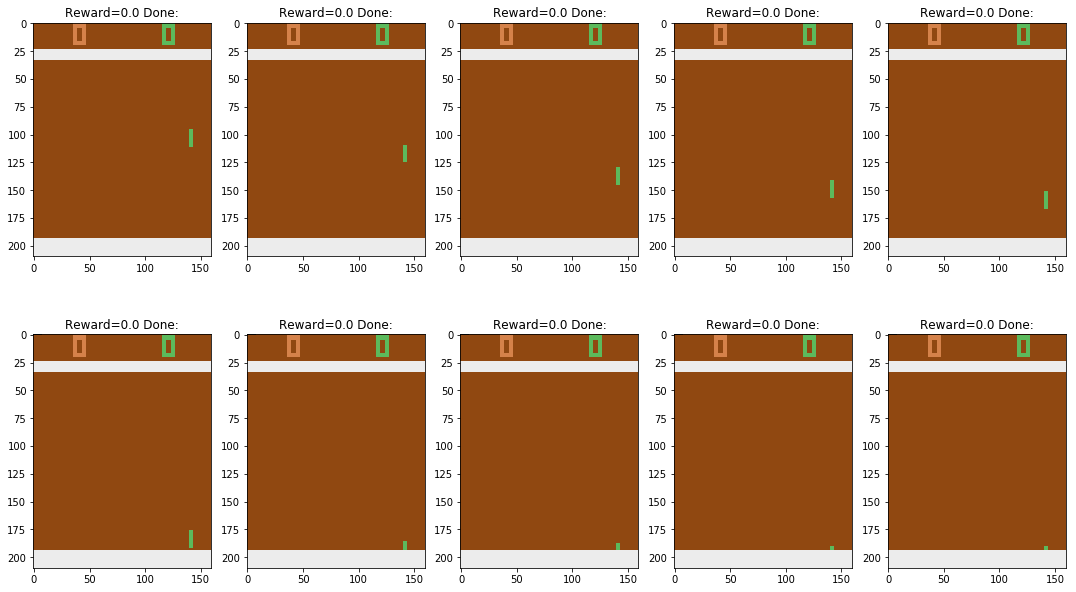

In [80]:
# env.reset()
i,j = 2,5
fig, axs = plt.subplots(i,j)
fig.set_size_inches(18.5, 10.5)
axs[0,0].imshow(observation)
for I in range(i):
    for J in range(j):
        _observation, reward, done, info = env.step(action=3)
        axs[I,J].imshow(_observation)
        axs[I,J].set_title('Reward=' + str(reward) + ' Done:' + ('DONE!!' if done==1 else ''))
        

In [ ]:
###########################

In [2]:
env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0
while True:
  if render: env.render()

  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
  aprob, h = policy_forward(x)
  action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

  # record various intermediates (needed later for backprop)
  xs.append(x) # observation
  hs.append(h) # hidden state
  y = 1 if action == 2 else 0 # a "fake label"
  dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
  observation, reward, done, info = env.step(action)
  reward_sum += reward

  drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

  if done: # an episode finished
    episode_number += 1

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
    epx = np.vstack(xs)
    eph = np.vstack(hs)
    epdlogp = np.vstack(dlogps)
    epr = np.vstack(drs)
    xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
    discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    discounted_epr -= np.mean(discounted_epr)
    discounted_epr /= np.std(discounted_epr)

    epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
    grad = policy_backward(eph, epdlogp)
    for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
    if episode_number % batch_size == 0:
      for k,v in model.items():
        g = grad_buffer[k] # gradient
        rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
        model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
        grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    print ('resetting env. episode reward total was {} running mean: {}'.format (reward_sum, running_reward))
    if episode_number % 100 == 0: pickle.dump(model, open('save.p', 'wb'))
    reward_sum = 0
    observation = env.reset() # reset env
    prev_x = None

  if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
    print ('ep {}: game finished, reward: {}'.format(episode_number, reward) + ('' if reward == -1 else ' !!!!!!!!'))
    

ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: 1.0 !!!!!!!!
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
resetting env. episode reward total was -20.0 running mean: -20.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: 1.0 !!!!!!!!
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0


ep 9: game finished, reward: 1.0 !!!!!!!!
ep 9: game finished, reward: -1.0
ep 9: game finished, reward: -1.0
resetting env. episode reward total was -19.0 running mean: -19.950891089105
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: 1.0 !!!!!!!!
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
resetting env. episode reward total

ep 19: game finished, reward: -1.0
ep 19: game finished, reward: 1.0 !!!!!!!!
ep 19: game finished, reward: -1.0
resetting env. episode reward total was -20.0 running mean: -19.993832999801644
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.00389466

ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
resetting env. episode reward total was -20.0 running mean: -20.014024666734368
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: gam

ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.07015534375544
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game

ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: 1.0 !!!!!!!!
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: 1.0 !!!!!!!!
ep 49: game finished, reward: -1.0
resetting env. episode reward total was -17.0 running mean: -20.119065160349706
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: 1.0 !!!!!!!!
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished,

ep 58: game finished, reward: -1.0
ep 58: game finished, reward: -1.0
ep 58: game finished, reward: -1.0
ep 58: game finished, reward: -1.0
resetting env. episode reward total was -16.0 running mean: -20.060025829115563
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
resetting env. episode reward total was -21.0

ep 68: game finished, reward: 1.0 !!!!!!!!
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: 1.0 !!!!!!!!
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: 1.0 !!!!!!!!
ep 68: game finished, reward: -1.0
resetting env. episode reward total was -18.0 running mean: -20.09087676193658
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: 1.0 !!!!!!!!
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game fi

ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: 1.0 !!!!!!!!
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0 running mean: -20.101291587613673
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward:

ep 87: game finished, reward: -1.0
ep 87: game finished, reward: -1.0
resetting env. episode reward total was -20.0 running mean: -20.082837258847427
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: 1.0 !!!!!!!!
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
resetting env. episode reward total was -20.0 running mean: -20.08200888

ep 97: game finished, reward: -1.0
ep 97: game finished, reward: -1.0
ep 97: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.10394797731656
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.112908497543398
e

ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.17060296893065
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
resetting env. episod

ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.211276755091085
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finishe

ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: 1.0 !!!!!!!!
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
resetting env. episode reward total was -20.0 running mean: -20.25747703366759
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: 1.0 !!!!!!!!
ep 128: game finished, reward: -1.0
ep 12

resetting env. episode reward total was -20.0 running mean: -20.293237569714076
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.300305194016936
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game

ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.31401852532791
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: 1.0 !!!!!!!!
ep 147: game 

ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.323772375616777
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: 1.0 !!!!!!!!
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game

ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.3598907054072
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: 1.0 !!!!!!!!
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game f

ep 175: game finished, reward: 1.0 !!!!!!!!
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
resetting env. episode reward total was -20.0 running mean: -20.349132156674184
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game

ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.393004169877383
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finishe

ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.40358078307987
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished

ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: 1.0 !!!!!!!!
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
resetting env. episode reward total was -19.0 running mean: -20.36809858135464
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game 

ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.38172716938923
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished

resetting env. episode reward total was -21.0 running mean: -20.38724887714824
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.39337638837676
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game f

ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.38761409655734
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: 1.0 !!!!!!!!
ep 234: game finished, reward: -1.0
ep 234: game 

ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.38859664602027
ep 244: game finished, reward: -1.0
ep 244: game finished, reward: -1.0
ep 244: game finished, reward: -1.0
ep 244: game finished, reward: -1.0
ep 244: game finished, reward: -1.0
ep 244: game finished, reward: -1.0
ep 244: game finished, reward: -1.0
ep 244: game finished, reward: -1.0
ep 244: game finished, reward: -1.0
ep 244: game finished, reward: -1.0
ep 244: game finished

ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: 1.0 !!!!!!!!
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: 1.0 !!!!!!!!
ep 253: game finished, reward: -1.0
resetting env. episode reward total was -19.0 running mean: -20.379688884143114
ep 254: game finished, reward: -1.0
ep 254: game finished, reward: -1.0
ep 254: game finished, reward: -1.0
ep 2

ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: 1.0 !!!!!!!!
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
resetting env. episode reward total was -19.0 running mean: -20.337052178298812
ep 263: game finished, reward: -1.0
ep 263: game finished, reward: -1.0
ep 263: game finished, reward: -1.0
ep 263: game finished, reward: -1.0
ep 263: game finished, reward: -1.0
ep 263: game finished, reward: -1.0
ep 263: game finished, reward: -1.0
ep 263: game finished, reward: -1.0
ep 263: game finished, reward: -1.0
ep 263: game finished, reward: -1.0
ep 263: game

ep 271: game finished, reward: -1.0
resetting env. episode reward total was -20.0 running mean: -20.346056019000244
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.352595458810242
ep 273: game finished, reward: -1.0
ep 273: game

ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: 1.0 !!!!!!!!
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
resetting env. episode reward total was -20.0 running mean: -20.3134683038758
ep 282: game finished, reward: -1.0
ep 282: game finished, reward: -1.0
ep 282: game finished, reward: -1.0
ep 282: game finished, reward: -1.0
ep 282: game finished, reward: -1.0
ep 282: game finished, reward: 1.0 !!!!!!!!
ep 282: game finished, reward: -1.0
ep 282: game finished, reward: -1.0
ep 282

resetting env. episode reward total was -21.0 running mean: -20.325458113813507
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: 1.0 !!!!!!!!
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
resetting env. episode reward total was -20.0 running mean: -20.32220353267537
ep 292: game finished, reward: -1.0
ep 29

ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: 1.0 !!!!!!!!
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
resetting env. episode reward total was -18.0 running mean: -20.29393082943398
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game 

ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: 1.0 !!!!!!!!
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
resetting env. episode reward total was -20.0 running mean: -20.332231778223765
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: 1.0 !!!!!!!!
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: -1.0
ep 3

ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
resetting env. episode reward total was -20.0 running mean: -20.312716368097377
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: 1.0 !!!!!!!!
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: 1.0 !!!!!!!!
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 3

ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.312116419472357
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
ep 330: game finishe

ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: 1.0 !!!!!!!!
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: 1.0 !!!!!!!!
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
resetting env. episode reward total was -19.0 running mean: -20.274165931248127
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 3

ep 347: game finished, reward: 1.0 !!!!!!!!
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
resetting env. episode reward total was -20.0 running mean: -20.23143355585871
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: 1.0 !!!!!!!!
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
reset

ep 357: game finished, reward: -1.0
ep 357: game finished, reward: 1.0 !!!!!!!!
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
resetting env. episode reward total was -20.0 running mean: -20.189219052853232
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game

ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
resetting env. episode reward total was -19.0 running mean: -20.19167951181301
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: 1.0 !!!!!!!!
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game 

ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: 1.0 !!!!!!!!
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0 running mean: -20.201682118209188
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: 1.0 !!!!!!!!
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -

ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
resetting env. episode reward total was -20.0 running mean: -20.183762687371193
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running me

ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.204360171227083
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finishe

ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.233736419268713
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finishe

ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.24206264573912
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mea

ep 424: game finished, reward: -1.0
ep 424: game finished, reward: -1.0
ep 424: game finished, reward: 1.0 !!!!!!!!
ep 424: game finished, reward: -1.0
ep 424: game finished, reward: 1.0 !!!!!!!!
ep 424: game finished, reward: 1.0 !!!!!!!!
ep 424: game finished, reward: -1.0
ep 424: game finished, reward: -1.0
ep 424: game finished, reward: -1.0
ep 424: game finished, reward: -1.0
ep 424: game finished, reward: -1.0
ep 424: game finished, reward: -1.0
ep 424: game finished, reward: -1.0
resetting env. episode reward total was -18.0 running mean: -20.246204341329864
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -

ep 433: game finished, reward: -1.0
ep 433: game finished, reward: 1.0 !!!!!!!!
ep 433: game finished, reward: 1.0 !!!!!!!!
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
resetting env. episode reward total was -19.0 running mean: -20.215214578747513
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: 1.0 !!!!!!!!
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -

resetting env. episode reward total was -19.0 running mean: -20.14874129777842
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: 1.0 !!!!!!!!
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
resetting env. episode reward total was -20.0 running mean: -20.147253884800637
ep 444: game finished, reward: -1.0
ep 44

ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.134138675517363
ep 453: game finished, reward: -1.0
ep 453: game finished, reward: -1.0
ep 453: game finished, reward: -1.0
ep 453: game finished, reward: -1.0
ep 453: game finished, reward: -1.0
ep 453: game finished, reward: -1.0
ep 453: game finished, reward: -1.0
ep 453: game finished, reward: -1.0
ep 453: game finished, reward: -1.0
ep 453: game finished, reward: -1.0
ep 453: game finishe

ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.095066151819378
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: 1.0 !!!!!!!!
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game

ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
resetting env. episode reward total was -20.0 running mean: -20.104321421188786
ep 472: game finished, reward: -1.0
ep 472: game finished, reward: -1.0
ep 472: game finished, reward: -1.0
ep 472: game finished, reward: -1.0
ep 472: game finished, reward: -1.0
ep 472: game finishe

ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.143917375666764
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finishe

ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.167834822782247
ep 491: game finished, reward: -1.0
ep 491: game finished, reward: -1.0
ep 491: game finished, reward: -1.0
ep 491: game finished, reward: -1.0
ep 491: game finished, reward: -1.0
ep 491: game finished, reward: -1.0
ep 491: game finished, reward: -1.0
ep 491: game finished, reward: -1.0
ep 491: game finished, reward: -1.0
ep 491: game finished, reward: -1.0
ep 491: game finished, reward: -1.0
ep 491: game finished, reward: -1.0
ep 491: game finishe

ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.190120457379557
ep 501: game finished, reward: -1.0
ep 501: game finished, reward: -1.0
ep 501: game finished, reward: -1.0
ep 501: game finished, reward: -1.0
ep 501: game finished, reward: -1.0
ep 501: game finishe

ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
resetting env. episode reward total was -21.0 running mean: -20.184348880562474
ep 510: game finished, reward: -1.0
ep 510: game finished, reward: -1.0
ep 510: game finished, reward: -1.0
ep 510: game finished, reward: -1.0
ep 510: game finished, reward: -1.0
ep 510: game finished, reward: -1.0
ep 510: game finished, reward: -1.0
ep 510: game finished, reward: -1.0
ep 510: game finished, reward: -1.0
ep 510: game finished, reward: -1.0
ep 510: game finished, reward: -1.0
ep 510: game finished, reward: -1.0
ep 510: game finished, reward: -1.0
ep 510: game finished, reward: -1.0
ep 510: game finished, reward: -1.0
ep 510: game finishe

ep 519: game finished, reward: -1.0
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: 1.0 !!!!!!!!
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: -1.0
resetting env. episode reward total was -20.0 running mean: -20.186141301639267
ep 520: game finished, reward: -1.0
ep 520: game finished, reward: -1.0
ep 520: game finished, reward: -1.0
ep 520: game finished, reward: -1.0
ep 520: game finished, reward: -1.0
ep 520: game finished, reward: -1.0
ep 520: game finished, reward: -1.0
ep 520: game

ep 528: game finished, reward: 1.0 !!!!!!!!
ep 528: game finished, reward: -1.0
ep 528: game finished, reward: -1.0
resetting env. episode reward total was -20.0 running mean: -20.217416091932886
ep 529: game finished, reward: -1.0
ep 529: game finished, reward: -1.0
ep 529: game finished, reward: -1.0
ep 529: game finished, reward: -1.0
ep 529: game finished, reward: -1.0
ep 529: game finished, reward: -1.0
ep 529: game finished, reward: -1.0
ep 529: game finished, reward: -1.0
ep 529: game finished, reward: -1.0
ep 529: game finished, reward: -1.0
ep 529: game finished, reward: -1.0
ep 529: game finished, reward: -1.0
ep 529: game finished, reward: -1.0
ep 529: game finished, reward: -1.0
ep 529: game finished, reward: -1.0
ep 529: game finished, reward: 1.0 !!!!!!!!
ep 529: game finished, reward: -1.0
ep 529: game finished, reward: -1.0
ep 529: game finished, reward: -1.0
ep 529: game finished, reward: -1.0
ep 529: game finished, reward: 1.0 !!!!!!!!
ep 529: game finished, reward: -

KeyboardInterrupt: 